In [21]:
from torch.utils.data import DataLoader


from refactor.utils.data import FilePaths, load_antibiotic_data
from refactor.utils.hooking import get_activations as get_activations_new
from refactor.utils.compatibility import ModelConfig
from refactor.probes import model_setup
from utils.probe_confidence_intervals import bootstrap

"""This function runs an entire pipeline that bootstraps, trains and creates confidence intervals showing
    The probes f1 score on different labels and across layers
    
    We bootstrap 10 times
    Results are saved in this folder: results/data/probe_confidence_intervals/*model_name*_reg_lambda_*reg_lambda*

Args:
    model_name (_type_): _description_
    reg_lambdas (_type_): _description_
"""

model_name = "downloaded_models/gpt_gptsw3_en_is_da_356m_gbs1024"
model_name = "EleutherAI/pythia-14m"

# loads model
print("Load model")
model, tokenizer, device = model_setup(model_name)


# loads data
print("Load data")
ds = load_antibiotic_data(
    file_paths=FilePaths.antibiotic,
    file_extension='txt'
)
loader = DataLoader(ds, batch_size=32, shuffle=True)



# sets training parameters
meta_data = {}
meta_data["hidden_size"] = ModelConfig.hidden_size(model)
meta_data["hidden_layers"] = ModelConfig.hidden_layers(model)
meta_data["model_name"] = model_name.split("/")[0]
meta_data["learning_rate"] = 0.001
meta_data["reg_lambda"] = 10
meta_data["amount_epochs"] = 1


# extracts activation from forward passes on data
# We use hooks to extract the different layer activations that will be used to train our probes

print("Extract activations")
activations = get_activations_new(
    loader=loader, 
    model=model,
    tokenizer=tokenizer,
    hook_addresses=None,
    layers=None,
    max_batches=2,
    sampling_prob=0.1
)

Load model
found device: cpu
Load data
Extract activations


  2%|▏         | 3/130 [00:02<01:27,  1.45it/s]


In [ ]:
import torch
flat_tensor = torch.cat(activations["layer.0.layernorm_1:pre"].predictors, dim=0)
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 5))
plt.hist(flat_tensor.numpy(), bins=50, color='skyblue', edgecolor='black')
plt.title('Activation Distribution')
plt.xlabel('Activation Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

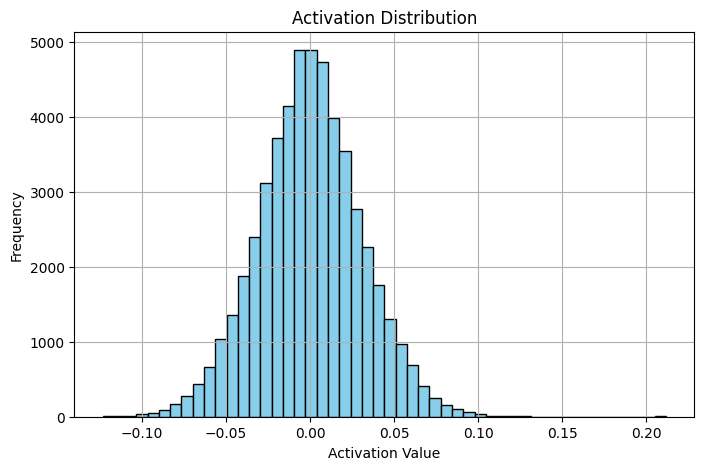

In [32]:
import torch
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 5))
plt.hist(flat_tensor.numpy(), bins=50, color='skyblue', edgecolor='black')
plt.title('Activation Distribution')
plt.xlabel('Activation Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [20]:
positions = []
for index, (key, val) in enumerate(activations.items()):
    if index == 6: break
    positions.append(key.replace("layer.0.",""))

In [4]:
d = {}
for pos in positions:
    acts_ds_by_layer = {}
    for layer in range(meta_data["hidden_layers"]):
        pos_key = f"layer.{layer}.{pos}"
        acts_ds_by_layer[layer] = activations[pos_key]
    d[pos] = acts_ds_by_layer



In [5]:
acts_ds_by_layer

{0: <refactor.utils.data.ActivationDataset at 0x30f6a9d30>,
 1: <refactor.utils.data.ActivationDataset at 0x310366f00>,
 2: <refactor.utils.data.ActivationDataset at 0x3103d46b0>,
 3: <refactor.utils.data.ActivationDataset at 0x3103d47d0>,
 4: <refactor.utils.data.ActivationDataset at 0x3103d49e0>,
 5: <refactor.utils.data.ActivationDataset at 0x3103d4c20>}

In [6]:
# extracts activation from forward passes on data
# We use hooks to extract the different layer activations that will be used to train our probes
from utils.probe_confidence_intervals import get_activations

print("Extract activations")
#activation_ds_by_layer = get_activations(meta_data,loader, tokenizer, device, model)



Extract activations


In [7]:
d

{'layernorm_1:pre': {0: <refactor.utils.data.ActivationDataset at 0x30f5f58b0>,
  1: <refactor.utils.data.ActivationDataset at 0x30f0857c0>,
  2: <refactor.utils.data.ActivationDataset at 0x310367410>,
  3: <refactor.utils.data.ActivationDataset at 0x3103d46e0>,
  4: <refactor.utils.data.ActivationDataset at 0x3103d4800>,
  5: <refactor.utils.data.ActivationDataset at 0x3103d4a40>},
 'attention:pre': {0: <refactor.utils.data.ActivationDataset at 0x30f65dfd0>,
  1: <refactor.utils.data.ActivationDataset at 0x30f085550>,
  2: <refactor.utils.data.ActivationDataset at 0x310366c90>,
  3: <refactor.utils.data.ActivationDataset at 0x3103d4710>,
  4: <refactor.utils.data.ActivationDataset at 0x3103d4860>,
  5: <refactor.utils.data.ActivationDataset at 0x3103d4aa0>},
 'attention:post': {0: <refactor.utils.data.ActivationDataset at 0x30f0d6120>,
  1: <refactor.utils.data.ActivationDataset at 0x310366210>,
  2: <refactor.utils.data.ActivationDataset at 0x3103d4620>,
  3: <refactor.utils.data.Act

In [50]:
import numpy as np

In [8]:
d["attention:pre"]

{0: <refactor.utils.data.ActivationDataset at 0x30f65dfd0>,
 1: <refactor.utils.data.ActivationDataset at 0x30f085550>,
 2: <refactor.utils.data.ActivationDataset at 0x310366c90>,
 3: <refactor.utils.data.ActivationDataset at 0x3103d4710>,
 4: <refactor.utils.data.ActivationDataset at 0x3103d4860>,
 5: <refactor.utils.data.ActivationDataset at 0x3103d4aa0>}

In [51]:
s = set()
for i in range(meta_data["hidden_layers"]):
    unique_labels = set(np.array(acts_ds_by_layer[i].labels))
    [s.add(x) for x in unique_labels]
number_labels = len(s)
meta_data["number_labels"] = number_labels

In [52]:
boot = bootstrap(10, meta_data, acts_ds_by_layer, device)

In [9]:
for pos in positions:
    print(pos)

layernorm_1:pre
attention:pre
attention:post
layernorm_2:pre
mlp:pre
mlp:post


In [16]:
from torch.utils.data import DataLoader
from refactor.utils.data import FilePaths, load_antibiotic_data
from refactor.utils.hooking import get_activations as get_activations_new
from refactor.utils.compatibility import ModelConfig
from refactor.probes import model_setup
from utils.probe_confidence_intervals import bootstrap
from collections import defaultdict
from pathlib import Path
import numpy as np
import json


"""This function runs an entire pipeline that bootstraps, trains and creates confidence intervals showing
    The probes f1 score on different labels and across layers
    
    We bootstrap 10 times
    Results are saved in this folder: results/data/probe_confidence_intervals/*model_name*_reg_lambda_*reg_lambda*

Args:
    model_name (_type_): _description_
    reg_lambdas (_type_): _description_
"""

# loads model
print("Load model")
model, tokenizer, device = model_setup(model_name)


# loads data
print("Load data")
ds = load_antibiotic_data(
    file_paths=FilePaths.antibiotic,
    file_extension='txt'
)
loader = DataLoader(ds, batch_size=32, shuffle=True)



# sets training parameters
meta_data = {}
meta_data["hidden_size"] = ModelConfig.hidden_size(model)
meta_data["hidden_layers"] = ModelConfig.hidden_layers(model)
meta_data["model_name"] = model_name.split("/")[0]
meta_data["learning_rate"] = 0.001
meta_data["reg_lambda"] = 10
meta_data["amount_epochs"] = 1


# extracts activation from forward passes on data
# We use hooks to extract the different layer activations that will be used to train our probes

print("Extract activations")
activations = get_activations_new(
    loader=loader, 
    model=model,
    tokenizer=tokenizer,
    hook_addresses=None,
    layers=None,
    max_batches=2,
    sampling_prob=0.1
)

#Here we get the different positions that we are testing
positions = []
for index, (key, val) in enumerate(activations.items()):
    if index == 6: break
    positions.append(key.replace("layer.0.",""))


d = {}
for pos in positions:
    acts_ds_by_layer = {}
    for layer in range(meta_data["hidden_layers"]):
        pos_key = f"layer.{layer}.{pos}"
        acts_ds_by_layer[layer] = activations[pos_key]
    d[pos] = acts_ds_by_layer

#We extract the amount of labels. 
#We just do this for a single position as all of them shares the same labels
s = set()
for i in range(meta_data["hidden_layers"]):
    unique_labels = set(np.array(acts_ds_by_layer[i].labels))
    [s.add(x) for x in unique_labels]
number_labels = len(s)
meta_data["number_labels"] = number_labels



data_output_folder = Path('results/data/probe_confidence_intervals')




Load model
found device: cpu
Load data
Extract activations


  2%|▏         | 3/130 [00:01<00:58,  2.17it/s]


In [17]:
model_name_temp = "test"
reg_lambdas = [1,2]
for pos in positions:
    
    acts_ds_by_layer = d[pos]
    print(acts_ds_by_layer, pos, "hi")
    for reg_lambda in reg_lambdas:
        #print()
        meta_data['reg_lambda'] = reg_lambda
        boot = bootstrap(10, meta_data, acts_ds_by_layer, device)
        map_lab = ds.map_label

        
        d = defaultdict(list)
        for run in boot:
            for layer in run.keys():
                class_accuracies = run[layer].class_accuracies
                d[layer].append(class_accuracies)



        # saves data used in plots
        
        d['map_label'] = map_lab

        reg_lambda_output_file = data_output_folder / f"{model_name_temp}_{pos}_reg_lambda_{meta_data['reg_lambda']}.json"
        with open(str(reg_lambda_output_file), 'w') as file:
            json.dump(d, file, indent=4)


{0: <refactor.utils.data.ActivationDataset object at 0x31039e360>, 1: <refactor.utils.data.ActivationDataset object at 0x30f6a9220>, 2: <refactor.utils.data.ActivationDataset object at 0x111cf73e0>, 3: <refactor.utils.data.ActivationDataset object at 0x31aba7170>, 4: <refactor.utils.data.ActivationDataset object at 0x316cf85f0>, 5: <refactor.utils.data.ActivationDataset object at 0x316cf8d10>} layernorm_1:pre hi
[] attention:pre hi


AttributeError: 'list' object has no attribute 'keys'